Final Python Assignment
==========
In this final project in Python we will have two classes (Parlament and Diputado) and we will work with data of the representatives of the Spanish Parlament. After some basic exploration on the data, we will use the images of the representatives in different fronts: k-means, PCA models, finding eigenvectors and finally we will train to predict some of the features of the representatives from their images using different basic machine learning algorithms.

In [1]:
from scipy import ndimage,misc
import numpy as np
import matplotlib.pyplot as plt
import csv

Diputado Class
-----
A diputado has a Name, Surnames, ID, Picture, Gender and Political Affiliation

In [2]:
%pylab inline
class Diputado(object):
    def __init__(self,ind,fileRoot="./"):
        self.name=""
        self.surname=""
        self.ind=ind
        self.picfile=""
        self.party=""
        self.gender=""
        self.fileRoot=fileRoot
        self.ext="c.jpg" 
    def setName(self,name):
        self.name=name
    def setSurname(self,surname):
        self.surname=surname
    def setParty(self,party):
        self.party=party
    def setGender(self,gender):
        self.gender=gender
    def getName(self):
        return self.name
    def getSurname(self):
        return self.surname
    def getInd(self):
        return self.ind
    def getPicfile(self):
        return self.fileRoot + str(self.ind) + self.ext
    def getParty(self):
        return self.party
    def getGender(self):
        return self.gender
       

Populating the interactive namespace from numpy and matplotlib


Parlament class
-----
Let's define a very simple Parlament object, where we store the diputados objects. From this class, we have to be able to get information from the parlament.

In [3]:
class Parlament(object):
    def __init__(self):
        self.elements=[]
        self.inds=[]
        self.ndips=0
    def add(self, diputado):
        self.elements.append(diputado)
        self.inds.append(diputado.getInd())
        self.ndips +=1
    def getInds(self):
        return [self.elements[i].getInd() for i in range(self.ndips)]
    def len(self):
        return len(self.elements)
    def __getitem__(self, key):
        if isinstance(key, slice):
            indices = key.indices(self.ndips)
            return [self[ii] for ii in xrange(*key.indices(self.len()))] 
        else:
            return self.elements[key]
    def getName(self,key):
        return self.elements[key].getName()
        

Reading data from the .csv file
=======
In this section we read the data from the provided .csv file and we produce some stats from it

In [4]:
with open('index.csv','r') as csvfile:
    r = csv.reader(csvfile, delimiter=';')
    r.__next__()
    p = Parlament()
    for row in r:
        n = Diputado(int(row[0]),"db/")
        n.setName(row[1].strip())
        n.setSurname(row[2].strip())
        n.setGender(row[3].strip())
        n.setParty(row[4].strip())
        p.add(n)

In [5]:
males = 0
females = 0

parties = {}

male_names = {}
female_names = {}
first_surnames = {}
second_surnames = {}

In [6]:
for diputado in p:
    if(diputado.gender == "H"):
        males += 1
        
        name = diputado.name
        
        if(name in male_names): male_names[name] += 1
        else: male_names[name] = 1
    
    elif(diputado.gender == "M"):
        females += 1
        
        name = diputado.name
        
        if(name in female_names): female_names[name] += 1
        else: female_names[name] = 1
    
    first_surname = diputado.surname.split()[0]
    
    if(first_surname in first_surnames): first_surnames[first_surname] += 1
    else: first_surnames[first_surname] = 1
    
    second_surname = diputado.surname.split()[1]
    
    if(second_surname in second_surnames): second_surnames[second_surname] += 1
    else: second_surnames[second_surname] = 1
    
    party = diputado.party
    
    if(party in parties): parties[party] += 1
    else: parties[party] = 1

### Most repeated names and surnames
In the case of the second surnames, we eliminated the two most popular ones ("i", "de")

In [7]:
from operator import itemgetter

print("Most repeated male names:", dict(sorted(male_names.items(), key = itemgetter(1), reverse = True)[:5]))
print("Most repeated female names:", dict(sorted(female_names.items(), key = itemgetter(1), reverse = True)[:5]))
print("Most repeated first surnames:", dict(sorted(first_surnames.items(), key = itemgetter(1), reverse = True)[:5]))
print("Most repeated second surnames:", dict(sorted(second_surnames.items(), key = itemgetter(1), reverse = True)[3:8]))

Most repeated male names: {'José': 7, 'Jordi': 6, 'Antonio': 6, 'Jesús': 5, 'Francisco': 5}
Most repeated female names: {'Carmen': 7, 'Ana María': 3, 'Pilar': 3, 'María Soraya': 2, 'María Soledad': 2}
Most repeated first surnames: {'Fernández': 9, 'Sánchez': 8, 'López': 7, 'González': 7, 'Torres': 6}
Most repeated second surnames: {'Rodríguez': 9, 'González': 6, 'López': 6, 'Díaz': 6, 'Pérez': 6}


### Male / female proportion

In [8]:
print("Male female proportion:", males/females, "males for each female.")

Male female proportion: 1.784 males for each female.


### Parties distribution

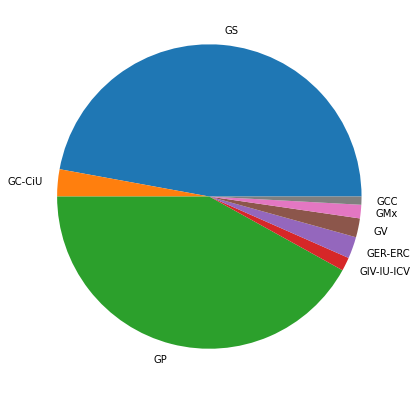

In [9]:
fig = plt.figure(figsize =(10, 7))
plt.pie(list(parties.values()), labels=list(parties.keys()))
plt.show()

Mean and standard deviation
====

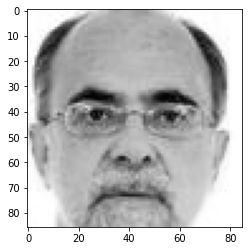

In [10]:
I = plt.imread(p[25].getPicfile()).mean(axis=2)
img=plt.imshow(I)
Is=shape(I)
plt.set_cmap('gray')

Creating an array with all the images and also with the corresponding genders and parties (will be used later in the predictions)

In [11]:
X = np.array([ plt.imread(d.getPicfile()).mean(axis=2).ravel()
             for d in p])
Yg = np.array([ d.getGender() for d in p])
Yp = np.array([ d.getParty() for d in p])

### Mean diputado

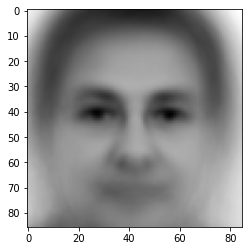

In [12]:
mX = X.mean(axis = 0)
plt.imshow(mX.reshape(Is))

### Median diputado

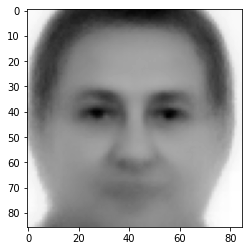

In [13]:
medX = np.median(X, axis = 0)
plt.imshow(medX.reshape(Is))

### Standard deviation

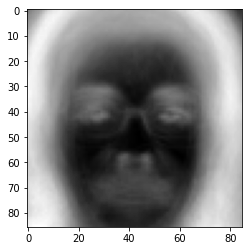

In [14]:
stdX = np.std(X, axis= 0)
plt.imshow(stdX.reshape(Is))

### "Confidence intervals" (mean +- sd)

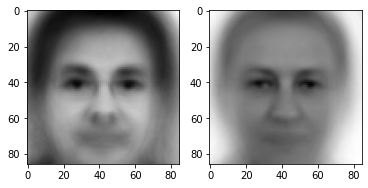

In [15]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow((mX - stdX).reshape(Is))
axarr[1].imshow((mX + stdX).reshape(Is))

k-means analysis
===

k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. We will classify our diputados in 10 groups using this technique.

In [16]:
from sklearn.cluster import KMeans

In [17]:
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X)
kmeans_pred = kmeans.fit_predict(X)

### Images for a given group

#### Group 0
In this group, most of the members are bald men, with a lot of them wearing glasses too.

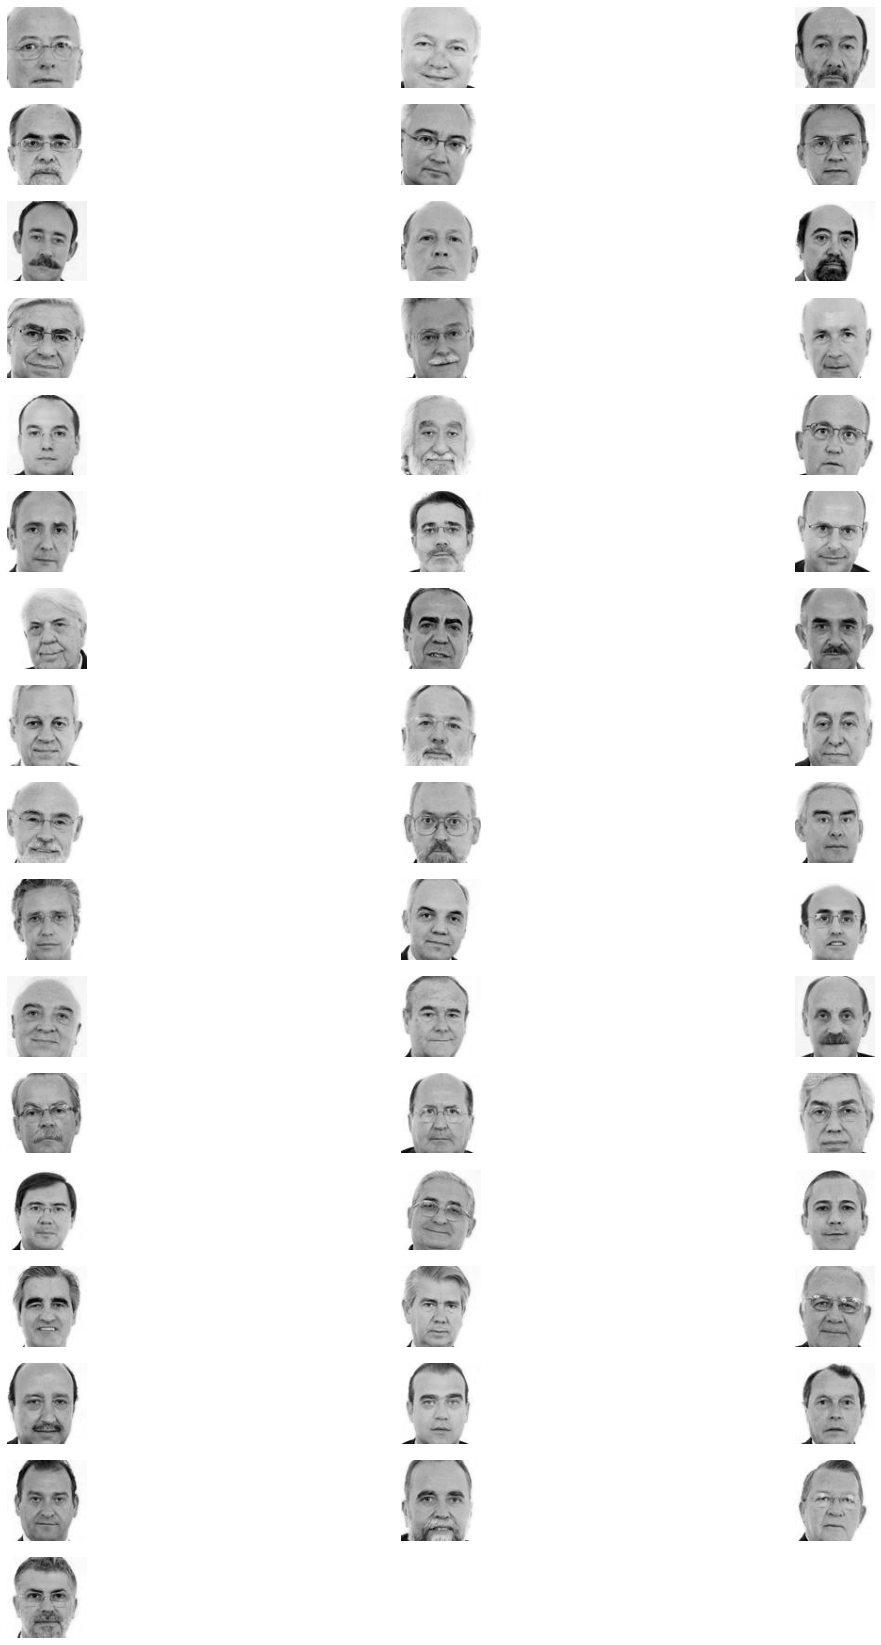

In [18]:
cluster_0 = np.where(kmeans_pred == 0)[0]

fig = plt.figure(figsize=(20, 30))
rows = int(len(cluster_0)/3) + 1
columns = 3
i = 1

for elem in cluster_0:
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.reshape(X[elem], Is))
    plt.axis('off')
    i += 1

#### Group 7
In this group, we have both men and women, with similar hairstyles

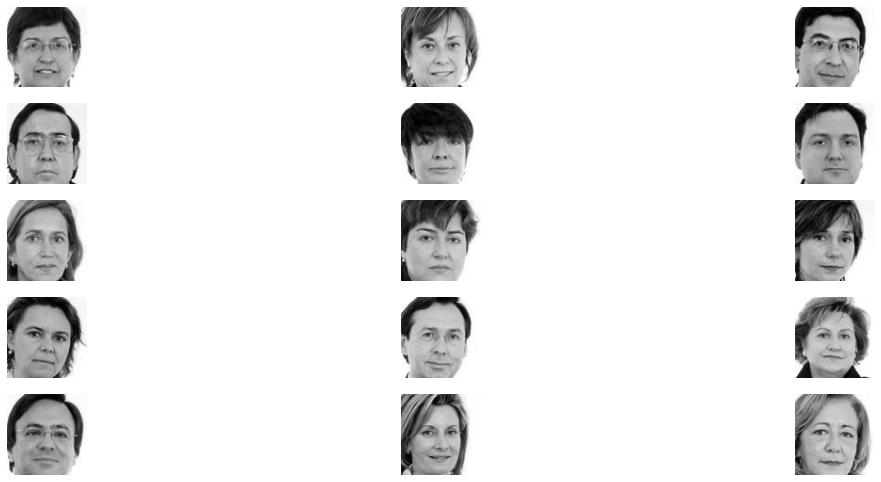

In [19]:
cluster_7 = np.where(kmeans_pred == 7)[0]

fig = plt.figure(figsize=(20, 30))
rows = int(len(cluster_0)/3) + 1
columns = 3
i = 1

for elem in cluster_7:
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.reshape(X[elem], Is))
    plt.axis('off')
    i += 1

### Centroids

In [20]:
centroids = kmeans.cluster_centers_

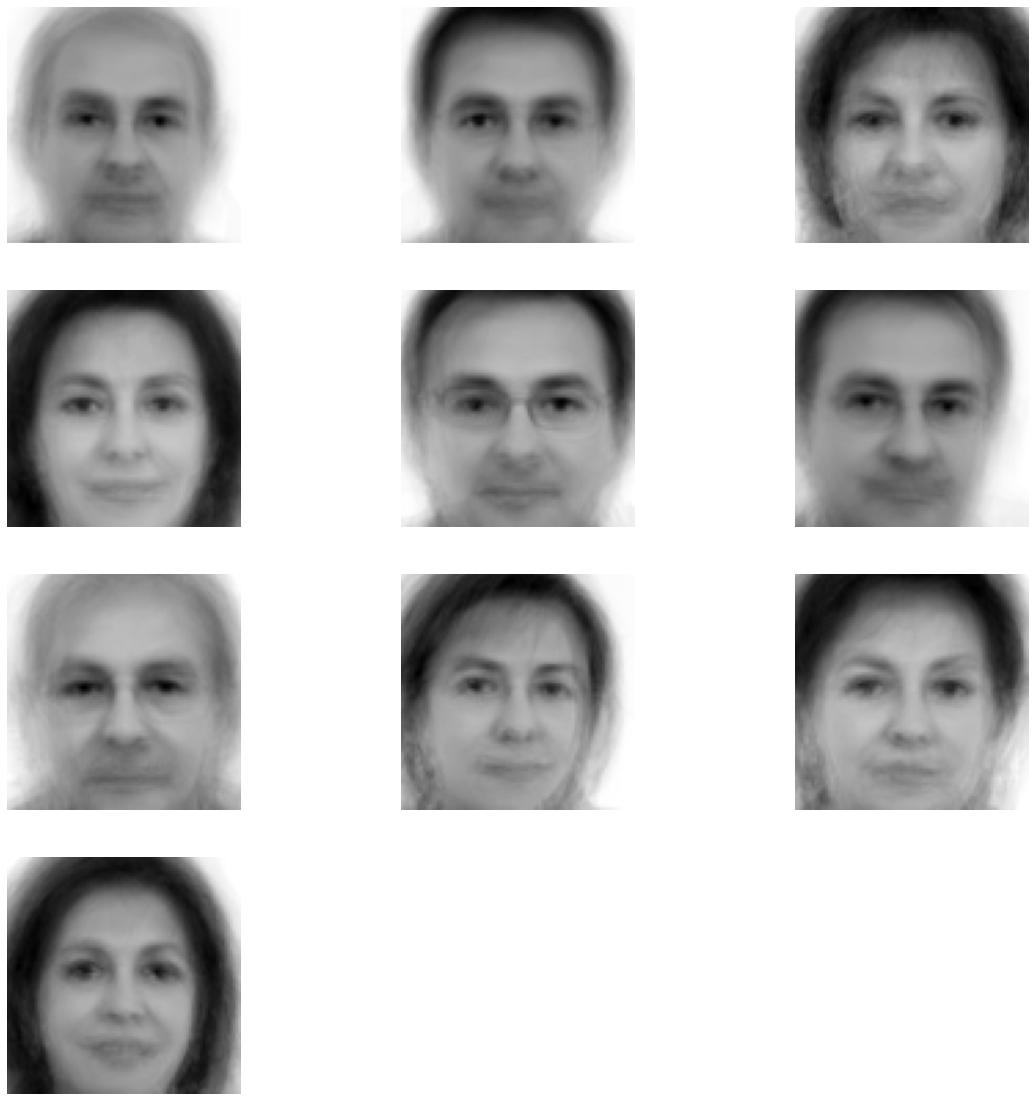

In [21]:
fig = plt.figure(figsize=(20, 20))
rows = 4
columns = 3
i = 1

for elem in centroids:
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.reshape(elem, Is))
    plt.axis('off')
    i += 1

PCA model
===

PCA is a statistical technique for reducing the dimensionality of a dataset. This is accomplished by linearly transforming the data into a new coordinate system where (most of) the variation in the data can be described with fewer dimensions than the initial data. We will use a PCA model of the images and see different characteristics of it.

In [22]:
from sklearn.decomposition import PCA
from sklearn import preprocessing 
import pandas as pd
import seaborn as sns

In [23]:
sX = preprocessing.scale(X)

In [24]:
mod = PCA( n_components= 10)
mod.fit(sX)

PCA(n_components=10)

### Eigenvectors

In [25]:
e = mod.components_.reshape( (10, Is[0], Is[1]) )

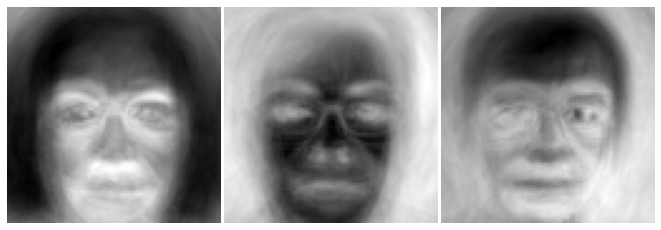

In [26]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(e[0])
plt.axis('off')

plt.subplot(132)
plt.imshow(e[1])
plt.axis('off')


plt.subplot(133)
plt.imshow(e[2])
plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01,
                  top=1, bottom=0, left=0, right=1)
plt.show()

#### Scatter plots

Here we plot the scores of the representatives according to the PCA model. The x-axis corresponds to the first principal component (1st eignevector) and the y-axis the second one.

In [27]:
T = mod.transform(sX)

Separating by gender. This plot is what we could expect by seeing the first and second eigenvectors. As the first one seems to clearly correspond to the characteristics of a women, most of the men are placed in the lower part of the x-axis and most of the women in the upper part. In terms of the second eigenvector, the distinction is not that clear.

<AxesSubplot:>

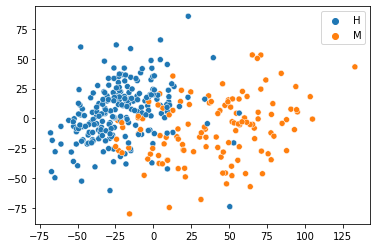

In [28]:
plt.figure()
sns.scatterplot(x=T[:,0],y=T[:,1], hue=Yg)

<AxesSubplot:>

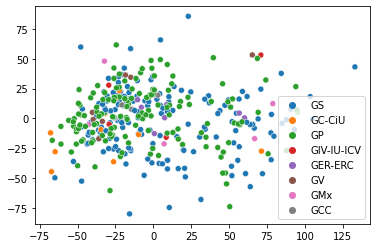

In [29]:
sns.scatterplot(x=T[:,0],y=T[:,1], hue=Yp)

Let's see the ratio of variance explained by each component of the PCA

In [30]:
print(mod.explained_variance_ratio_)

[0.21359515 0.08745176 0.07300043 0.05175998 0.04675874 0.03813754
 0.03018139 0.01984962 0.01821858 0.01590594]


#### Interactive plot

In [31]:
from ipywidgets import widgets

In [32]:
A = widgets.FloatSlider(min = -10, max = 10, step = 1, description="A")
B = widgets.FloatSlider(min = -10, max = 10, step = 1, description="B")
ui = widgets.HBox( [A,B] )

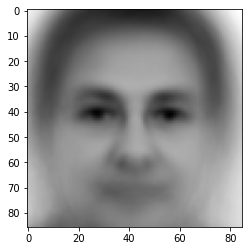

In [33]:
def plot(A, B):
    plt.imshow(mX.reshape(Is) + A*e[0] + B*e[1])
    
out = widgets.interactive_output(plot, {'A': A, 'B': B})

In [34]:
display(out, ui)

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


## Prediction models

### Gender predictors

First of all, we will try with a Random Forest Classifier. To see the accuracy of the model, we will split the data into two groups, the train and test one. Without lost of generality, we can do it splitting by first m elements and last n-m elements.

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [36]:
rfc = RandomForestClassifier()

In [37]:
m = 65

In [38]:
# Train the model, with the first m elements
rfc.fit(X[:m], Yg[:m])

RandomForestClassifier()

In [39]:
accuracy_score(rfc.predict(X[m:]), Yg[m:])

0.8763250883392226

Training with half of the images, we get an score around 85% when predicting the other half with a basic Random Forest Classifier.

In [40]:
m = 100
rfc.fit(X[:m], Yg[:m])
accuracy_score(rfc.predict(X[m:]), Yg[m:])

0.9112903225806451

Increasing the training data to 100 elements, we get accuracies around 90%. We conclude that for predicting the gender, this kind of predictor is enough.

### Party predictors

In [41]:
m = 65

In [42]:
rfc.fit(X[:m], Yp[:m])

RandomForestClassifier()

In [43]:
accuracy_score(rfc.predict(X[m:]), Yp[m:])

0.38869257950530034

In [44]:
m = 100
rfc.fit(X[:m], Yp[:m])
accuracy_score(rfc.predict(X[m:]), Yp[m:])

0.29435483870967744

In this case, the images of the "diputados" do not seem enough to determine their political party using a Random Forest Classifier. We will use other techniques.

In [45]:
from sklearn.svm import SVC

In [46]:
clf = SVC(kernel='rbf')

In [47]:
m = 65
clf.fit(X[:m], Yp[:m])

SVC()

In [48]:
accuracy_score(clf.predict(X[m:]), Yp[m:])

0.38515901060070673

In [49]:
m = 100
clf.fit(X[:m], Yp[:m])
accuracy_score(rfc.predict(X[m:]), Yp[m:])

0.29435483870967744

Using Support Vector Machines, we do not really improve the accuracy

Extra: trying another dataset
===

We will try a bigger dataset. We got celebrity pictures from the source CelebA Dataset (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). It is also included as a zip at the task in Atenea. The .txt file 'modified.txt' contains attributes about the faces of the celebrities (see the column names for it). We will focus on the gender prediction ('Male' column). Although the dataset contains more than 200000 images, we will work with 3000 of them to make it easier to compile and process the data.

In [50]:
attrib = pd.read_csv('modified.txt', sep=",", header=0)

In [51]:
attrib.columns

Index(['Image', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'Unnamed: 41'],
      dtype='object')

In [52]:
import os

In [53]:
path = 'img_align_celeba/'
count = 0

for file in os.listdir(path):
    count += 1
print(count)

2999


In [54]:
# We remove the data we do not need (we are using only 3000 images) and we stay only with the attributes that
# are likely to predict the gender

attrib = attrib.iloc[:2999]
attrib = attrib.loc[:, ['Image', 'Male', 'Bald', 'Big_Lips', 'Heavy_Makeup', 'Mustache', 'No_Beard',
                        'Rosy_Cheeks', 'Sideburns', 'Wearing_Earrings', 'Wearing_Lipstick']]

First, we will use the images to try to predict the gender

In [55]:
from PIL import Image

In [56]:
X = []

for file in os.listdir(path):
    image = Image.open(path + file)
    X.append(np.array(image.resize((86, 85))).mean(axis=2).ravel())

X = np.array(X)
Yg = attrib['Male']

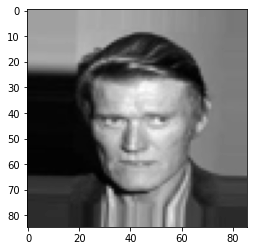

In [57]:
plt.imshow(np.array(image.resize((86, 85))).mean(axis=2))

We see an example of image of this dataset. As we can see, the images will not be as clean as the ones in the parlament (no white back of the image, subject not looking at the camera,...)

In [58]:
print(X.shape)
print(Yg.shape)

(2999, 7310)
(2999,)


In [59]:
clf = SVC(kernel='rbf')

In [60]:
m = 2800

In [61]:
clf.fit(X[:m], Yg[:m])

SVC()

In [62]:
accuracy_score(clf.predict(X[m:]), Yg[m:])

0.5829145728643216

The performance is not very good (if we assigned random genders the performance would be around 50%, so it does not improve much from a random model. Moreover, this Support Vector Machines model takes time to be fitted. The images are not as well formatted as the ones in the previous dataset (not everyone is looking at the camera, the back of the photo is not white,...). A good approach can be to use the other attributes we have from the celebrities, the ones that we expect that are useful to predict the gender.

In [63]:
gender_attributes = attrib.loc[:, ['Bald', 'Big_Lips', 'Heavy_Makeup', 'Mustache', 'No_Beard',
                        'Rosy_Cheeks', 'Sideburns', 'Wearing_Earrings', 'Wearing_Lipstick']]

In [64]:
X_attr = np.array(gender_attributes)

In [65]:
clf.fit(X_attr[:m], Yg[:m])

SVC()

In [66]:
accuracy_score(clf.predict(X_attr[m:]), Yg[m:])

0.9396984924623115

We see that using these attributes, the performance of the model improves to a great 94% accuracy. Let's make m smaller, to train the model only with half of the data.

In [67]:
m = 1500
clf.fit(X_attr[:m], Yg[:m])
accuracy_score(clf.predict(X_attr[m:]), Yg[m:])

0.9119412941961308

The accuracy is still pretty good. A good approach now would be trying to predict some of the key attributes for the gender from the pictures.

In [68]:
clf = SVC(kernel='rbf')
m = 2000

In [69]:
Y_bald = attrib.loc[:, 'Bald']
clf.fit(X[:m], Y_bald[:m])
accuracy_score(clf.predict(X[m:]), Y_bald[m:])

0.973973973973974

In [70]:
Y_hm = attrib.loc[:, 'Heavy_Makeup']
clf.fit(X[:m], Y_hm[:m])
accuracy_score(clf.predict(X[m:]), Y_hm[m:])

0.6096096096096096

In [71]:
Y_mus = attrib.loc[:, 'Mustache']
clf.fit(X[:m], Y_mus[:m])
accuracy_score(clf.predict(X[m:]), Y_mus[m:])

0.9629629629629629

In [72]:
Y_wl = attrib.loc[:, 'Wearing_Lipstick']
clf.fit(X[:m], Y_wl[:m])
accuracy_score(clf.predict(X[m:]), Y_wl[m:])

0.5005005005005005

In [73]:
Y_rc = attrib.loc[:, 'Rosy_Cheeks']
clf.fit(X[:m], Y_rc[:m])
accuracy_score(clf.predict(X[m:]), Y_rc[m:])

0.9459459459459459

In [74]:
Y_sb = attrib.loc[:, 'Sideburns']
clf.fit(X[:m], Y_sb[:m])
accuracy_score(clf.predict(X[m:]), Y_sb[m:])

0.944944944944945

In [75]:
Y_nb = attrib.loc[:, 'No_Beard']
clf.fit(X[:m], Y_nb[:m])
accuracy_score(clf.predict(X[m:]), Y_nb[m:])

0.8298298298298298

In [76]:
Y_we = attrib.loc[:, 'Wearing_Earrings']
clf.fit(X[:m], Y_we[:m])
accuracy_score(clf.predict(X[m:]), Y_we[m:])

0.8028028028028028

We see that from the images, we can predict with great accuracy the attributes 'Bald', 'Mustache','Rosy_Cheeks', 'Sideburns', 'No_Beard'. Let's see if this attributes are enough to predict with good accuracy the gender.

In [77]:
X_attrib = attrib.loc[:, ['Bald', 'Mustache', 'Rosy_Cheeks', 'Sideburns', 'No_Beard']]

In [78]:
clf.fit(X_attrib[:m], Yg[:m])
accuracy_score(clf.predict(X_attrib[m:]), Yg[m:])

0.7757757757757757

We see that the performance arrives to almost an 80%. Now, let's try the flux, Images -> Predict attributes -> Predict gender. We split the data in 3 parts of 1000. We will train a model from the images to predict the attributes and, from that, we will train a model with the obtained results to predict the gender.

In [79]:
X_attrib_2 = pd.DataFrame(columns = ['Bald', 'Mustache', 'Rosy_Cheeks', 'Sideburns', 'No_Beard'])

for attribute in ['Bald', 'Mustache', 'Rosy_Cheeks', 'Sideburns', 'No_Beard']:
    Y_attrib = attrib.loc[:, attribute]
    clf.fit(X[:1000], Y_attrib[:1000])
    X_attrib_2[attribute] = clf.predict(X[1000:2000])

In [80]:
clf.fit(X_attrib_2, Yg[1000:2000])
accuracy_score(clf.predict(X_attrib[2000:]), Yg[2000:])

0.5905905905905906

The performance with this mixed model does not significantly improve with respect to using just images. We could expect this, as at the end we are using only the images to predict.

Some next steps to improve the performance could be:
- Try to use a bigger number of images, we used only 2000 of them to priorize speed but we had more than 200000 available in this dataset.
- Try to clean the images. Detect the face and whiten the back of the image could help in increasing the performance.
- Get rid of the pictures in which the subject does not look to the camera.